# Covid Cases Dataset
_____

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

import plotly.figure_factory as ft 

In [71]:
df_cases = pd.read_csv('../data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
df_cases = df_cases[['submission_date','state','tot_cases','new_case','tot_death','new_death']]
df_cases.head()

,submission_date,state,tot_cases,new_case,tot_death,new_death
0,01/25/2020,OR,0,0,0,0
1,09/17/2021,MD,"516,784","1,525","10,282",11
2,10/12/2021,VT,"33,388",112,333,4
3,02/01/2021,DC,"37,008",136,916,3
4,12/19/2021,NC,"1,586,243","3,410","19,480",19


In [72]:
df_cases['submission_date'] = pd.to_datetime(df_cases['submission_date'])

In [73]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59640 entries, 0 to 59639
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   submission_date  59640 non-null  datetime64[ns]
 1   state            59640 non-null  object        
 2   tot_cases        59640 non-null  object        
 3   new_case         59640 non-null  object        
 4   tot_death        59640 non-null  object        
 5   new_death        59640 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 2.7+ MB


In [74]:
df_cases.set_index('submission_date', inplace=True)
df_cases.sort_index(inplace=True)

In [75]:
df_cases.columns

Index(['state', 'tot_cases', 'new_case', 'tot_death', 'new_death'], dtype='object')

In [76]:
df_cases['tot_cases'].value_counts()

0            4117
4             578
1             280
3             195
2             161
             ... 
401,591         1
526,423         1
815,593         1
621,542         1
7,135,916       1
Name: tot_cases, Length: 42844, dtype: int64

In [77]:
df_cases['new_case'].value_counts()

0         14040
1           346
2           277
3           185
4           167
          ...  
13,181        1
10,421        1
21,940        1
16,373        1
5,470         1
Name: new_case, Length: 8121, dtype: int64

In [78]:
col =['tot_cases', 'new_case', 'tot_death', 'new_death']
for c in col:
    df_cases[c] = df_cases[c].map( lambda x: x.replace(',','')).astype(int)
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [79]:
df_cases[df_cases['tot_cases']==0].count()

state        4117
tot_cases    4117
new_case     4117
tot_death    4117
new_death    4117
dtype: int64

In [80]:
df_cases.head(70)

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2020-01-23,PR,0,0,0,0
2020-01-23,LA,0,0,0,0
2020-01-23,OR,0,0,0,0


In [81]:
#df_cases.drop(df_cases[df_cases['tot_cases']==0].index, inplace=True)

In [82]:
df_cases.shape

(59640, 5)

In [83]:
df_cases.head(70)

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2020-01-23,PR,0,0,0,0
2020-01-23,LA,0,0,0,0
2020-01-23,OR,0,0,0,0


##  EDA - Covid Cases in US 
_____

In [84]:
# Creating a copy of dataset to perform EDA
df_deaths = df_cases.copy()

df = df_cases.copy()


In [85]:
# I will perform EDA in US cases so I need to sum cases from all states.
# to do this I will sum the cases for the same dates using group by.
# I can't use tot_cases because this column is acumulative so I will sum the new cases.
df = df.groupby(by=df.index).sum()
df.head()

,tot_cases,new_case,tot_death,new_death
submission_date,,,,
2020-01-22,4,4,0,0
2020-01-23,6,2,0,0
2020-01-24,7,1,0,0
2020-01-25,7,0,0,0
2020-01-26,8,1,0,0


In [86]:
df.drop(columns=['tot_cases','tot_death','new_death'], inplace=True)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 994 entries, 2020-01-22 to 2022-10-11
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   new_case  994 non-null    int64
dtypes: int64(1)
memory usage: 15.5 KB


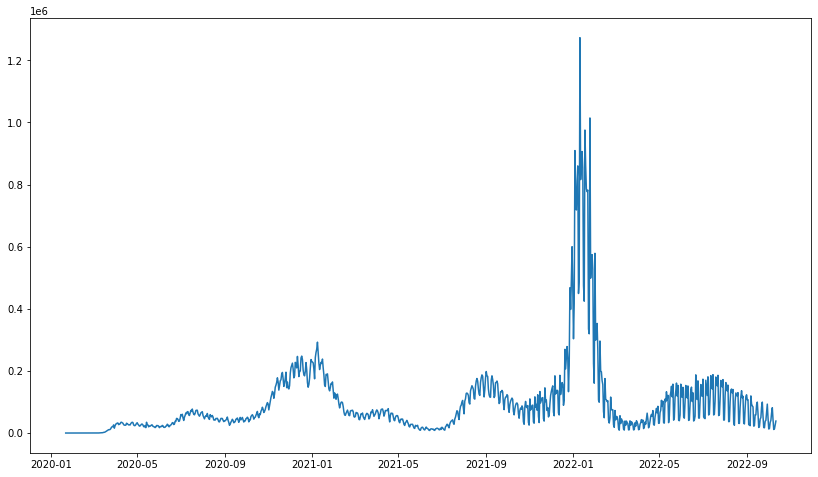

In [88]:
plt.figure(figsize=(14,8))
plt.plot(df['new_case']);

In [89]:
df = df.resample('W').mean()
df_cases_diff = df.copy()
df.head()

,new_case
submission_date,
2020-01-26,1.600000
2020-02-02,0.714286
2020-02-09,1.000000
2020-02-16,0.571429
2020-02-23,3.428571


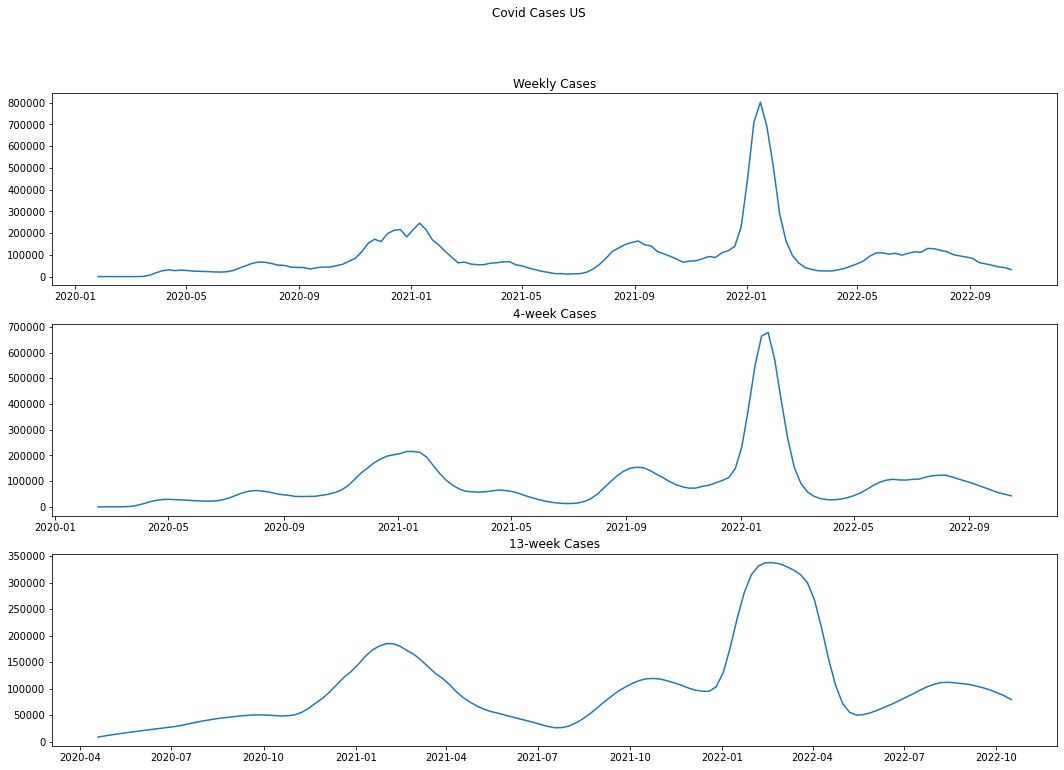

In [90]:
df['moving_average_1'] = df['new_case'].rolling(window=1).mean()
df['moving_average_4'] = df['new_case'].rolling(window=4).mean()
df['moving_average_13'] = df['new_case'].rolling(window=13).mean()

fig, axes = plt.subplots(nrows=3, figsize=(18,12))

axes[0].plot(df['moving_average_1'])
axes[1].plot(df['moving_average_4'])
axes[2].plot(df['moving_average_13'])


fig.suptitle('Covid Cases US')
axes[0].title.set_text('Weekly Cases')
axes[1].title.set_text('4-week Cases')
axes[2].title.set_text('13-week Cases')



In [91]:
df.dropna(inplace=True)
df.head()

,new_case,moving_average_1,moving_average_4,moving_average_13
submission_date,,,,
2020-04-19,27436.857143,27436.857143,25772.964286,8494.298901
2020-04-26,30087.571429,30087.571429,28939.857143,10808.604396
2020-05-03,27584.571429,27584.571429,29096.714286,12930.439560
2020-05-10,24957.142857,24957.142857,27516.535714,14850.142857
2020-05-17,24088.142857,24088.142857,26679.357143,16703.032967


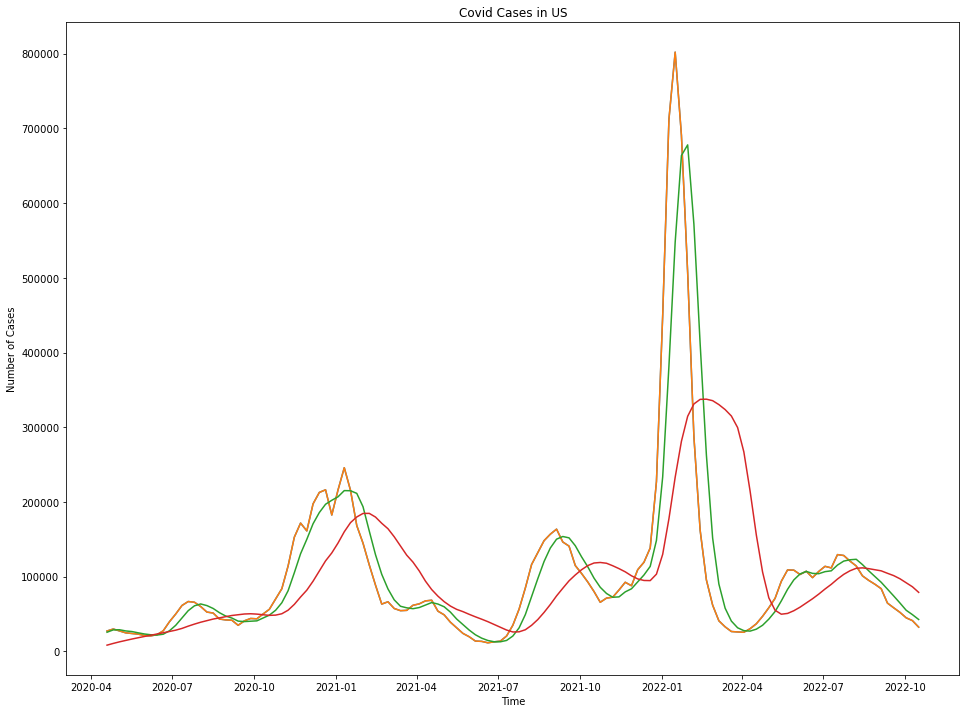

In [92]:
plt.figure(figsize=(16,12))
plt.plot(df)
plt.title('Covid Cases in US')
plt.xlabel('Time')
plt.ylabel('Number of Cases');

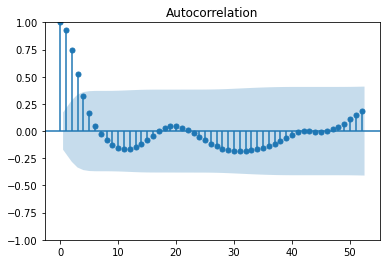

In [93]:
# Generate the ACF plot on Weekly Sales data up to 52 time periods.
plot_acf(df['new_case'], lags = 52);

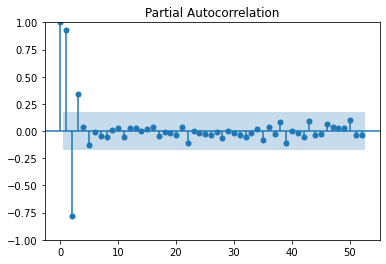

In [94]:
plot_pacf(df['new_case'], lags = 52, method='ywm' );

### Evaluating Stationary
---

In [95]:
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df['new_case']))

Test Statistic   -3.264758
p-value           0.016529
dtype: float64

` Because our p (0.016529) is bigger than alpha (0.01) we can not  accept that our series "new_cases" is stationary.`

In [96]:
# Create train-test split.
y_train, y_test = train_test_split(df['new_case'], test_size = 0.1,shuffle = False)

In [97]:
y_train.tail()

submission_date
2022-06-12    107407.571429
2022-06-19     98857.285714
2022-06-26    107148.714286
2022-07-03    113983.857143
2022-07-10    111881.000000
Freq: W-SUN, Name: new_case, dtype: float64

In [98]:
y_test.head()

submission_date
2022-07-17    129685.285714
2022-07-24    128469.285714
2022-07-31    120971.000000
2022-08-07    114476.428571
2022-08-14    101213.571429
Freq: W-SUN, Name: new_case, dtype: float64

In [99]:
# Instantiate best model.
#arima_5201 = ARIMA(endog = y_train, order = (52, 0, 1))
arima_5201 = ARIMA(endog = y_train, order = (3, 0, 1))

# Fit ARIMA model.
model_5201 = arima_5201.fit()

In [100]:
# Generate predictions based on test set.
preds_5201 = model_5201.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_5201 = model_5201.predict(start = y_train.index[0], end = y_train.index[-1])

In [101]:
from sklearn import metrics
metrics.mean_squared_error(y_test, preds_5201)

1670139099.9838376

Text(0.5, 1.0, 'Weekly Sales for Store 1 with ARIMA(3, 0, 1) Predictions')

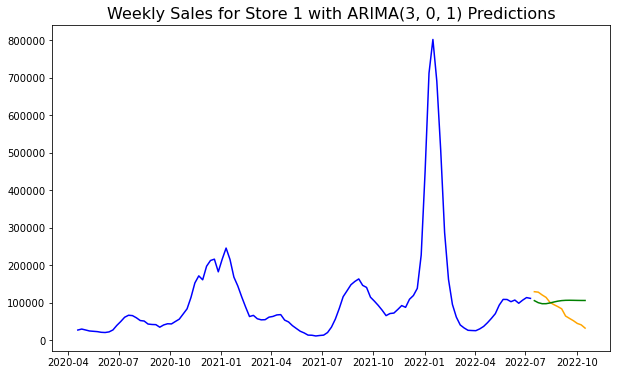

In [102]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_5201, color = 'green')

plt.title(label = 'Weekly Sales for Store 1 with ARIMA(3, 0, 1) Predictions', fontsize=16)

### SARIMA
----

In [103]:
# Fit a SARIMA(3, 0, 1) x (1, 1, 1, 22) model.
sarima = SARIMAX(endog = y_train,
                  order = (3, 0, 1),                # (p, d, q)
                  seasonal_order=(1,1,1,22))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01876D+01    |proj g|=  1.53410D+00

At iterate    5    f=  9.61380D+00    |proj g|=  4.07625D-02

At iterate   10    f=  9.60119D+00    |proj g|=  5.82532D-03

At iterate   15    f=  9.59915D+00    |proj g|=  1.00264D-03

At iterate   20    f=  9.59915D+00    |proj g|=  1.96093D-04

At iterate   25    f=  9.59912D+00    |proj g|=  1.21219D-03

At iterate   30    f=  9.59910D+00    |proj g|=  3.42874D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [104]:
# Generate predictions based on test set.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])

In [105]:
# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

436284355.8369504

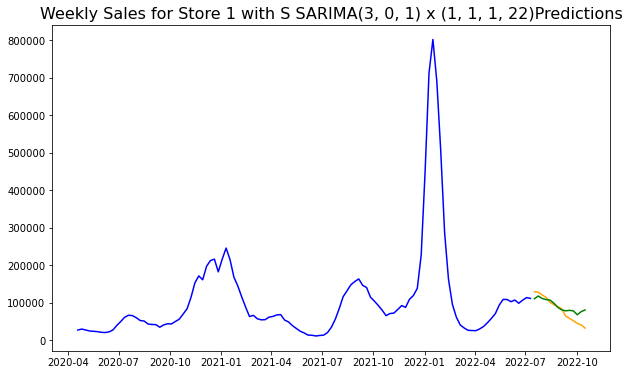

In [106]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

    #order = (3, 0, 1),                # (p, d, q)
     # seasonal_order=(1,1,1,22))     

plt.title(label = 'Weekly Sales for Store 1 with S SARIMA(3, 0, 1) x (1, 1, 1, 22)Predictions', fontsize=16)
plt.show();

In [107]:
df_cases.head()

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0


In [108]:
df_cases_diff.head()

,new_case
submission_date,
2020-01-26,1.600000
2020-02-02,0.714286
2020-02-09,1.000000
2020-02-16,0.571429
2020-02-23,3.428571


In [109]:
df_cases_diff['diff_1'] = df_cases_diff['new_case'].diff()
df_cases_diff['diff_2'] = df_cases_diff['new_case'].diff().diff()
df_cases_diff.head()

,new_case,diff_1,diff_2
submission_date,,,
2020-01-26,1.600000,NaN,NaN
2020-02-02,0.714286,-0.885714,NaN
2020-02-09,1.000000,0.285714,1.171429
2020-02-16,0.571429,-0.428571,-0.714286
2020-02-23,3.428571,2.857143,3.285714


In [110]:
df_cases_diff.dropna(inplace=True)
df_cases_diff.head()

,new_case,diff_1,diff_2
submission_date,,,
2020-02-09,1.000000,0.285714,1.171429
2020-02-16,0.571429,-0.428571,-0.714286
2020-02-23,3.428571,2.857143,3.285714
2020-03-01,7.428571,4.000000,1.142857
2020-03-08,103.142857,95.714286,91.714286


In [159]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df_cases_diff['new_case']))

Test Statistic   -3.320787
p-value           0.013974
dtype: float64

In [112]:
# Create train-test split.
y_train, y_test = train_test_split(df_cases_diff['new_case'], test_size = 0.1,shuffle = False)

In [113]:
y_train.tail()

submission_date
2022-06-05    103067.428571
2022-06-12    107407.571429
2022-06-19     98857.285714
2022-06-26    107148.714286
2022-07-03    113983.857143
Freq: W-SUN, Name: new_case, dtype: float64

In [114]:
y_test.head()

submission_date
2022-07-10    111881.000000
2022-07-17    129685.285714
2022-07-24    128469.285714
2022-07-31    120971.000000
2022-08-07    114476.428571
Freq: W-SUN, Name: new_case, dtype: float64

In [115]:
# Fit a SARIMA(2, 0, 2) x (1, 1, 1, 52) model.
#CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
#Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,16).
#This model has an MSE of 990000000000000000.
#(1,0,0): 328044210.2485147
#(3,1,1):1835103241.9625137
sarima = SARIMAX(endog = y_train,
                  order = (1, 0, 0),                # (p, d, q)
                  seasonal_order=(0,0,0,22))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21685D+01    |proj g|=  2.14268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.274D-06   1.217D+01
  F =   12.168175861504078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [116]:
# Generate predictions based on test set. # Evaluate predictions MSE.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])
# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

328044210.2485147

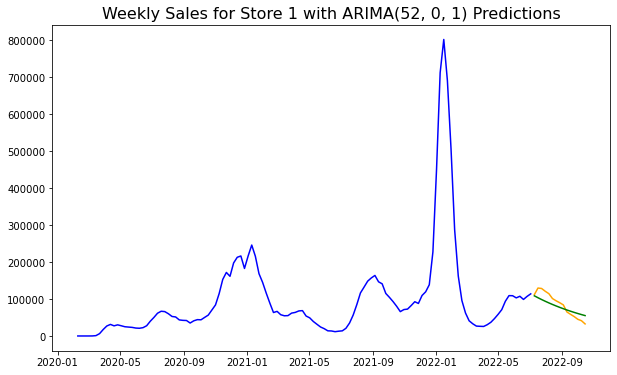

In [117]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

plt.title(label = 'Weekly Sales for Store 1 with ARIMA(52, 0, 1) Predictions', fontsize=16)
plt.show();

In [118]:
y_train.shape

(126,)

In [119]:
y_test.shape

(15,)

In [120]:

# Create train-test split.
y_train, y_test = train_test_split(df_cases_diff['new_case'], test_size = 0.1,shuffle = False)

In [121]:
mse = 99 * (10 ** 16)
mse

990000000000000000

In [122]:
metrics.mean_squared_error(y_test, preds_sarima)


328044210.2485147

In [123]:
# Starting MSE and (P, D, Q).
#mse = 99 * (10 ** 16)
#final_p = 0
#final_d = 0
#final_q = 0
#final_P = 0
#final_D = 0
#final_Q = 0
#for p in range(2):
#    for q in range(2):
#        for d in range(2):
#            for P in range(3):
#                for Q in range(3):
#                    for D in range(3):
#                        try:
#                            sarima = SARIMAX(endog = y_train,
#                                            order = (p, d, q),              # (p, d, q)
#                                            seasonal_order = (P, D, Q, 22))  # (P, D, Q, S)
                            
#                           print(P, D, Q)
#                            # Fit SARIMA model.
#                            model = sarima.fit()
#                            preds_sarima = model.predict(start = y_test.index[0], end = y_test.index[-1])
#                            print(f'The MSE for ({p}, {d}, {q})x({P},{D},{Q},22) is: {metrics.mean_squared_error(y_test, preds_sarima)}')#

                                            # Save for final report.
#                            if mse > metrics.mean_squared_error(y_test, preds_sarima):
#                                mse = metrics.mean_squared_error(y_test, preds_sarima)
                                
#                                final_p = p
#                                final_d = d
#                                final_q = q
#                                final_P = P
#                                final_D = D
#                                final_Q = Q

                            
#                        except:
#                            print("Exceprtion hahppened")
#                            pass
#print(f'Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q},22).')
#print(f'This model has an MSE of {mse}.')

In [124]:
# 27690096390.04778
# 31324938754.810467
# 328044210.2485147
# CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
# The MSE for (1, 1, 1)x(2,2,2,22) is: 31324938754.810467

# Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,22).
# This model has an MSE of 328044210.2485147.

### Cases by State
____

In [125]:
df_cases.head()

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0


In [126]:
df_cases.groupby(by='state').sum()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,103800015,282632,533125,1186
AL,638327202,1528319,10915844,20498
AR,403775153,954552,5830937,12041
AS,1382283,8250,5776,34
AZ,978893192,2275235,15992140,31644
CA,4364733842,11107087,50457009,95414
CO,658900625,1660829,6600246,13348
CT,367082955,888009,7159317,11385
DC,64506024,168122,929885,1383


In [127]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [128]:
df_cases.head(60).sort_values(by='state')

df_ = df_cases.loc['2022-06':'2022-10'].groupby(by='state').sum()

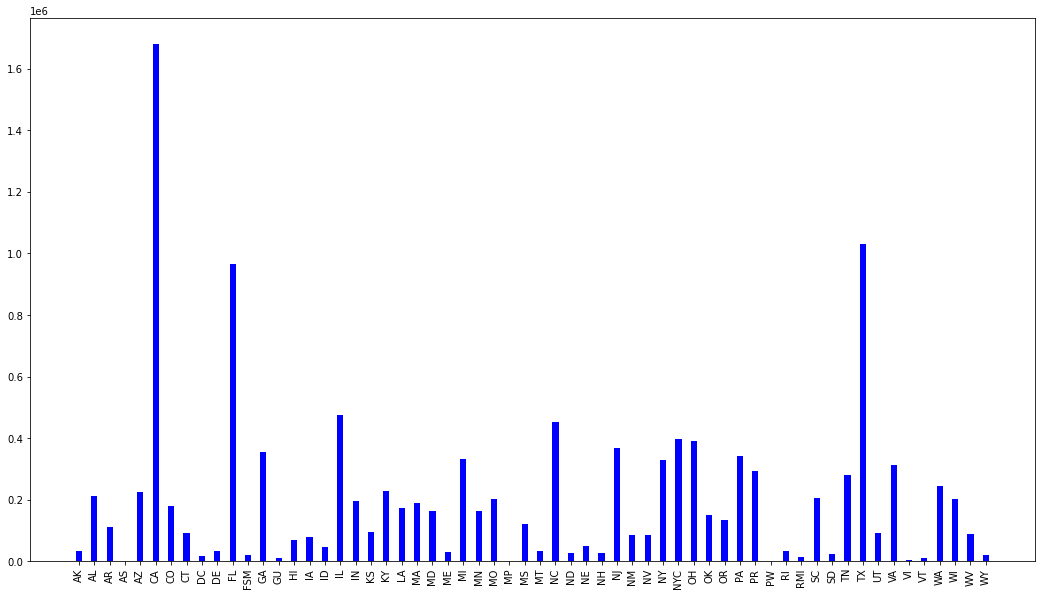

In [129]:

df_.head()
# create data
plt.figure(figsize=(18,10))
x = df_.index
y1 = df_['new_case']
#y2 = df_['tot_death']
width = 0.40
  
# plot data in grouped manner of bar type
plt.bar(x, y1, width, color='b')
#plt.bar(x, y2, width, color='r')
plt.xticks(rotation=90);


In [130]:
df_cases.groupby(by='state').sum().T

state,AK,AL,AR,AS,AZ,CA,CO,CT,DC,DE,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
tot_cases,103800015,638327202,403775153,1382283,978893192,4364733842,658900625,367082955,64506024,123511033,...,985632802,3307212352,451582481,800947192,7188849,42676851,644705150,775370683,219275324,74375640
new_case,282632,1528319,954552,8250,2275235,11107087,1660829,888009,168122,310527,...,2327351,7691340,1040147,2099126,23103,133252,1825126,1875895,603256,177635
tot_death,533125,10915844,5830937,5776,15992140,50457009,6600246,7159317,929885,1674285,...,12689455,47538683,2350692,10365763,52258,288765,6442064,7409068,3159079,845670
new_death,1186,20498,12041,34,31644,95414,13348,11385,1383,3094,...,25437,89344,5018,21986,123,698,14417,15321,7387,1904


In [131]:
df_cases.groupby(by='state').sum()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,103800015,282632,533125,1186
AL,638327202,1528319,10915844,20498
AR,403775153,954552,5830937,12041
AS,1382283,8250,5776,34
AZ,978893192,2275235,15992140,31644
CA,4364733842,11107087,50457009,95414
CO,658900625,1660829,6600246,13348
CT,367082955,888009,7159317,11385
DC,64506024,168122,929885,1383


In [132]:
df_cases.groupby(by='state').sum().shape

(60, 4)

In [133]:
df_fips = pd.read_csv('../data/states_fips.csv')
df_fips.head(50)

,name,postal_code,fips
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6
5,Colorado,CO,8
6,Connecticut,CT,9
7,Delaware,DE,10
8,District of Columbia,DC,11
9,Florida,FL,12


In [134]:
list_state = list(df_cases.groupby(by='state').sum().index)
list_state

['AK',
 'AL',
 'AR',
 'AS',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'FSM',
 'GA',
 'GU',
 'HI',
 'IA',
 'ID',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'ME',
 'MI',
 'MN',
 'MO',
 'MP',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NH',
 'NJ',
 'NM',
 'NV',
 'NY',
 'NYC',
 'OH',
 'OK',
 'OR',
 'PA',
 'PR',
 'PW',
 'RI',
 'RMI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VA',
 'VI',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY']

In [135]:
list_fips = list(df_fips['postal_code'])
list_fips

['AL',
 'AK',
 'AZ',
 'AR',
 'CA',
 'CO',
 'CT',
 'DE',
 'DC',
 'FL',
 'GA',
 'HI',
 'ID',
 'IL',
 'IN',
 'IA',
 'KS',
 'KY',
 'LA',
 'ME',
 'MD',
 'MA',
 'MI',
 'MN',
 'MS',
 'MO',
 'MT',
 'NE',
 'NV',
 'NH',
 'NJ',
 'NM',
 'NY',
 'NC',
 'ND',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VT',
 'VA',
 'WA',
 'WV',
 'WI',
 'WY',
 'AS',
 'GU',
 'MP',
 'PR',
 'VI']

In [136]:
set(list_state) - set(list_fips)

{'FSM', 'NYC', 'PW', 'RMI'}

In [137]:
# These are not US state
# FSM: Federated States of Micronesia
# PW: Palau
# RMI: Republic of Marshall Islands
not_state_list = ['FSM', 'PW', 'RMI', 'AS', 'GU', 'MP', 'PR', 'VI']

In [138]:
df_us = df_cases.groupby(by='state').sum()
df_us.shape

(60, 4)

In [139]:
df_us.loc['FSM']

tot_cases    753724
new_case      22005
tot_death      1997
new_death        51
Name: FSM, dtype: int64

In [140]:
# Deleting theses 'states' ['FSM', 'PW', 'RMI', 'AS', 'GU', 'MP', 'PR', 'VI']
# Keeping DC and NYC. Total of 52 'US states'
df_us.drop(index=not_state_list,inplace=True)
df_us.shape

(52, 4)

In [141]:
df_us.sort_index()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,103800015,282632,533125,1186
AL,638327202,1528319,10915844,20498
AR,403775153,954552,5830937,12041
AZ,978893192,2275235,15992140,31644
CA,4364733842,11107087,50457009,95414
CO,658900625,1660829,6600246,13348
CT,367082955,888009,7159317,11385
DC,64506024,168122,929885,1383
DE,123511033,310527,1674285,3094


In [142]:
##!pip install plotly-geo==1.0.0
##!pip install geopandas==0.3.0
##!pip install pyshp==1.2.10
##!pip install shapely==1.6.3

In [143]:
import plotly.graph_objects as go
import pandas as pd
import geopandas as gpd

In [144]:
import plotly.graph_objects as go

import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')
fig = go.Figure(
    data = go.Choropleth(
    locations = df['code'], # Spatial coordinates
    z = df['total exports'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = ' US Covid Cases by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

## EDA - COVID Deaths in US
____

In [145]:
df_deaths.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 4.7+ MB


In [146]:
df_deaths = df_deaths.groupby(by=df_deaths.index).sum()
df_deaths.head()

,tot_cases,new_case,tot_death,new_death
submission_date,,,,
2020-01-22,4,4,0,0
2020-01-23,6,2,0,0
2020-01-24,7,1,0,0
2020-01-25,7,0,0,0
2020-01-26,8,1,0,0


In [147]:
df_deaths.drop(columns=['tot_cases','tot_death','new_case'], inplace=True)


In [148]:
df_deaths.sort_values(by='new_death', ascending=True)

,new_death
submission_date,
2020-01-22,0
2020-02-12,0
2020-02-13,0
2020-02-14,0
2020-02-15,0
...,...
2021-01-28,3880
2021-01-27,3955
2021-01-07,4000


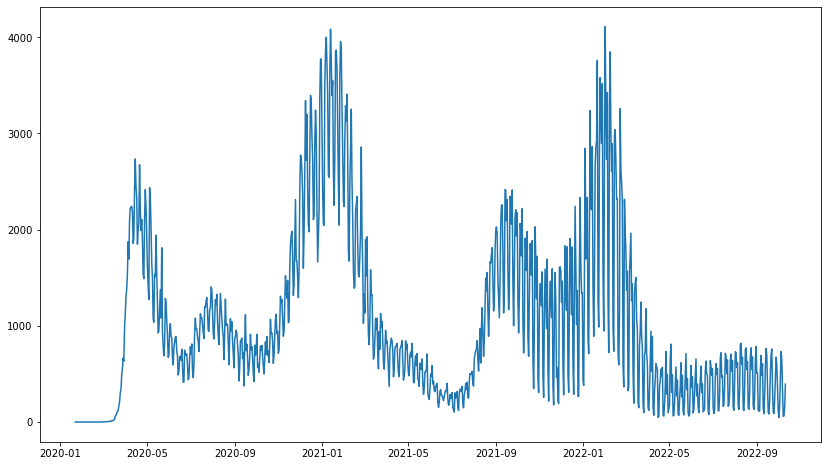

In [149]:
plt.figure(figsize=(14,8))
plt.plot(df_deaths['new_death']);

# Vacination data
____


In [193]:
df_vacc=pd.read_csv('../data/covid_vaccination_trends.csv', low_memory=False)
df_vacc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74160 entries, 0 to 74159
Data columns (total 25 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Date                                         74160 non-null  object 
 1   date_type                                    74160 non-null  object 
 2   MMWR_week                                    74160 non-null  int64  
 3   Location                                     74160 non-null  object 
 4   Administered_Daily                           74160 non-null  object 
 5   Administered_Cumulative                      74160 non-null  object 
 6   Administered_7_Day_Rolling_Average           73140 non-null  object 
 7   Admin_Dose_1_Daily                           74160 non-null  object 
 8   Admin_Dose_1_Cumulative                      74160 non-null  object 
 9   Admin_Dose_1_Day_Rolling_Average             73140 non-null  object 
 10

In [196]:
df_vacc.head()

,date_type,MMWR_week,Location,Administered_Daily,Administered_Cumulative,Administered_7_Day_Rolling_Average,Admin_Dose_1_Daily,Admin_Dose_1_Cumulative,Admin_Dose_1_Day_Rolling_Average,Administered_Dose1_Pop_Pct,...,Series_Complete_Day_Rolling_Average,Series_Complete_Pop_Pct,Booster_Daily,Booster_Cumulative,Booster_7_Day_Rolling_Average,Additional_Doses_Vax_Pct,Second_Booster_50Plus_Daily,Second_Booster_50Plus_Cumulative,Second_Booster_50Plus_7_Day_Rolling_Average,Second_Booster_50Plus_Vax_Pct
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-13,Report,51,GU,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,Report,51,FM,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,Admin,51,MA,2,2,2,22,22,22,0.0,...,4,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,Report,51,NY,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,Admin,51,AZ,"4,423","4,423","4,423","3,116","3,116","3,116",0.0,...,"1,097",0.0,0,0,0,0.0,0,0,0,0.0


In [197]:
df_vacc['Location'].value_counts()

GU    1236
FM    1236
ME    1236
WV    1236
OR    1236
IN    1236
CT    1236
HI    1236
TN    1236
DC    1236
MD    1236
ID    1236
MT    1236
UT    1236
ND    1236
OK    1236
MI    1236
DE    1236
AR    1236
IL    1236
US    1236
GA    1236
CA    1236
WY    1236
NH    1236
LA    1236
FL    1236
VT    1236
PA    1236
AK    1236
WI    1236
NV    1236
TX    1236
MA    1236
NY    1236
AZ    1236
NJ    1236
IA    1236
OH    1236
MO    1236
KS    1236
MN    1236
VI    1236
KY    1236
MH    1236
WA    1236
NE    1236
SD    1236
NC    1236
MP    1236
VA    1236
PW    1236
RI    1236
NM    1236
AL    1236
AS    1236
SC    1236
PR    1236
MS    1236
CO    1236
Name: Location, dtype: int64

In [194]:
df_vacc['Date'] = pd.to_datetime(df_vacc['Date'])
df_vacc.set_index('Date', inplace=True)
df_vacc.sort_index(inplace=True)
df_vacc.head(20)


,date_type,MMWR_week,Location,Administered_Daily,Administered_Cumulative,Administered_7_Day_Rolling_Average,Admin_Dose_1_Daily,Admin_Dose_1_Cumulative,Admin_Dose_1_Day_Rolling_Average,Administered_Dose1_Pop_Pct,...,Series_Complete_Day_Rolling_Average,Series_Complete_Pop_Pct,Booster_Daily,Booster_Cumulative,Booster_7_Day_Rolling_Average,Additional_Doses_Vax_Pct,Second_Booster_50Plus_Daily,Second_Booster_50Plus_Cumulative,Second_Booster_50Plus_7_Day_Rolling_Average,Second_Booster_50Plus_Vax_Pct
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-13,Report,51,GU,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,Report,51,FM,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,Admin,51,MA,2,2,2,22,22,22,0.0,...,4,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,Report,51,NY,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,Admin,51,AZ,"4,423","4,423","4,423","3,116","3,116","3,116",0.0,...,"1,097",0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,Admin,51,NJ,"1,342","1,342","1,342","1,083","1,083","1,083",0.0,...,515,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,Report,51,IA,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,Report,51,MA,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,Admin,51,OH,4,4,4,48,48,48,0.0,...,13,0.0,0,0,0,0.0,0,0,0,0.0


In [179]:
df_cases.head()

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0


In [198]:
df_v = df_vacc[['Location','Administered_Daily']].head()
df_v['Location'].head()

Date
2020-12-13    GU
2020-12-13    FM
2020-12-13    MA
2020-12-13    NY
2020-12-13    AZ
Name: Location, dtype: object

In [195]:
df_v.value_counts()

Location  Administered_Daily
AZ        4,423                 1
FM        0                     1
GU        0                     1
MA        2                     1
NY        0                     1
dtype: int64

In [182]:
df_var = pd.merge(df_cases, df_v, left_index=True, right_index=True)
df_var.head(10)

,state,tot_cases,new_case,tot_death,new_death,Location,Administered_Daily
2020-12-13,GA,542838,4798,10076,1,GU,0
2020-12-13,GA,542838,4798,10076,1,FM,0
2020-12-13,GA,542838,4798,10076,1,MA,2
2020-12-13,GA,542838,4798,10076,1,NY,0
2020-12-13,GA,542838,4798,10076,1,AZ,"4,423"
2020-12-13,NYC,369000,3871,24339,31,GU,0
2020-12-13,NYC,369000,3871,24339,31,FM,0
2020-12-13,NYC,369000,3871,24339,31,MA,2
2020-12-13,NYC,369000,3871,24339,31,NY,0
2020-12-13,NYC,369000,3871,24339,31,AZ,"4,423"


In [168]:
df_vacc.columns

Index(['date_type', 'MMWR_week', 'Location', 'Administered_Daily',
       'Administered_Cumulative', 'Administered_7_Day_Rolling_Average',
       'Admin_Dose_1_Daily', 'Admin_Dose_1_Cumulative',
       'Admin_Dose_1_Day_Rolling_Average', 'Administered_Dose1_Pop_Pct',
       'Administered_daily_change_report',
       'Administered_daily_change_report_7dayroll', 'Series_Complete_Daily',
       'Series_Complete_Cumulative', 'Series_Complete_Day_Rolling_Average',
       'Series_Complete_Pop_Pct', 'Booster_Daily', 'Booster_Cumulative',
       'Booster_7_Day_Rolling_Average', 'Additional_Doses_Vax_Pct',
       'Second_Booster_50Plus_Daily', 'Second_Booster_50Plus_Cumulative',
       'Second_Booster_50Plus_7_Day_Rolling_Average',
       'Second_Booster_50Plus_Vax_Pct'],
      dtype='object')

In [163]:
df_vacc.drop(columns=['date_type','MMWR_week'],inplace=True)
df_vacc

,Location,Administered_Daily,Administered_Cumulative,Administered_7_Day_Rolling_Average,Admin_Dose_1_Daily,Admin_Dose_1_Cumulative,Admin_Dose_1_Day_Rolling_Average,Administered_Dose1_Pop_Pct,Administered_daily_change_report,Administered_daily_change_report_7dayroll,...,Series_Complete_Day_Rolling_Average,Series_Complete_Pop_Pct,Booster_Daily,Booster_Cumulative,Booster_7_Day_Rolling_Average,Additional_Doses_Vax_Pct,Second_Booster_50Plus_Daily,Second_Booster_50Plus_Cumulative,Second_Booster_50Plus_7_Day_Rolling_Average,Second_Booster_50Plus_Vax_Pct
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-13,GU,0,0,0,0,0,0,0.0,0,0,...,0,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,FM,0,0,0,0,0,0,0.0,0,0,...,0,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,MA,2,2,2,22,22,22,0.0,2,2,...,4,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,NY,0,0,0,0,0,0,0.0,0,0,...,0,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,AZ,"4,423","4,423","4,423","3,116","3,116","3,116",0.0,"4,423","4,423",...,"1,097",0.0,0,0,0,0.0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-12,AS,42,"114,422",NaN,7,"46,004",NaN,95.0,NaN,NaN,...,NaN,89.5,16,"24,539",NaN,57.9,12,"2,030",NaN,24.3
2022-10-12,RI,"20,905","2,447,927",NaN,"3,397","1,095,356",NaN,95.0,NaN,NaN,...,NaN,85.9,"2,067","515,043",NaN,56.6,"5,104","120,835",NaN,40.7
2022-10-12,AL,"18,544","6,649,782",NaN,"2,490","3,148,955",NaN,64.2,NaN,NaN,...,NaN,52.4,"2,835","983,521",NaN,38.3,"5,307","194,224",NaN,27.1


In [164]:
df_vacc.drop(columns=['Administered_Daily', 'Administered_Cumulative',
       'Administered_7_Day_Rolling_Average', 'Admin_Dose_1_Daily', 'Admin_Dose_1_Day_Rolling_Average',
       'Administered_Dose1_Pop_Pct', 'Administered_daily_change_report',
       'Administered_daily_change_report_7dayroll', 'Series_Complete_Daily',
       'Series_Complete_Cumulative', 'Series_Complete_Day_Rolling_Average',
       'Series_Complete_Pop_Pct', 'Booster_Daily', 'Booster_Cumulative',
       'Booster_7_Day_Rolling_Average', 'Additional_Doses_Vax_Pct',
       'Second_Booster_50Plus_Daily', 'Second_Booster_50Plus_Cumulative',
       'Second_Booster_50Plus_7_Day_Rolling_Average',
       'Second_Booster_50Plus_Vax_Pct'],inplace=True)


In [165]:
df_vacc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74160 entries, 2020-12-13 to 2022-10-12
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Location                 74160 non-null  object
 1   Admin_Dose_1_Cumulative  74160 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [156]:
df_vacc['Admin_Dose_1_Cumulative'] = df_vacc['Admin_Dose_1_Cumulative'].map( lambda x: x.replace(',','')).astype(int)
df_vacc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74160 entries, 2020-12-13 to 2022-10-12
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Location                 74160 non-null  object
 1   Admin_Dose_1_Cumulative  74160 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [157]:
df_vacc = df_vacc.groupby(by=df_vacc.index).sum()
df_vacc.head()

,Admin_Dose_1_Cumulative
Date,
2020-12-13,63478
2020-12-14,72612
2020-12-15,164862
2020-12-16,474783
2020-12-17,1009666


In [158]:
df_vacc.head(70)

,Admin_Dose_1_Cumulative
Date,
2020-12-13,63478
2020-12-14,72612
2020-12-15,164862
2020-12-16,474783
2020-12-17,1009666
...,...
2021-02-16,159035888
2021-02-17,162004921
2021-02-18,165071278
